# Model demo

In [1]:
from model import Model
from dmchunk import Chunk
import numpy as np
import matplotlib.pyplot as plt

## Creating a model

In [3]:
m = Model()

We can use `print(m)` to print an overview of the model:

In [5]:
print(m)


=== Model ===
Time: 0 s 
Goal:None
Imaginal:None
DM:



## Setting a goal

Add a chunk to the model's goal buffer. We can specify a chunk name and any number of slots (as a dictionary). Here we first create a chunk with the name "goal-chunk" that has two slots.

In [15]:
g = Chunk(name = "goal-chunk", slots = {"goal": "count", "current": "two"})
m.goal = g

Check that the goal is added to the model:

In [14]:
print(m)


=== Model ===
Time: 0 s 
Goal:Chunk goal-chunk
Slots: {'goal': 'count', 'current': 'two'}
Encounters: []
Fan: 0

Imaginal:None
DM:



## Adding chunks to memory

Here we add some chunks to the model's declarative memory (at t = 0).

In [18]:
c1 = Chunk(name = "c1", slots = {"type": "numbers", "val1": 1, "val2": 2, "word": "two"})
c2 = Chunk(name = "c2", slots = {"type": "numbers", "val1": 2, "val2": 3, "word": "three"})

m.add_encounter(c1)
m.add_encounter(c2)

Add some more encounters of these chunks.

In [21]:
m.time += 15 # Advance the model time by 15 seconds
m.add_encounter(c2)

m.time += 20
m.add_encounter(c1)

m.time += 5
m.add_encounter(c2)

Let's see what the model looks like now:

In [24]:
print(m)


=== Model ===
Time: 40 s 
Goal:Chunk goal-chunk
Slots: {'goal': 'count', 'current': 'two'}
Encounters: []
Fan: 0

Imaginal:None
DM:Chunk c1
Slots: {'type': 'numbers', 'val1': 1, 'val2': 2, 'word': 'two'}
Encounters: [0, 35]
Fan: 0

Chunk numbers
Slots: {'name': 'numbers'}
Encounters: [0]
Fan: 3

Chunk two
Slots: {'name': 'two'}
Encounters: [0]
Fan: 2

Chunk c2
Slots: {'type': 'numbers', 'val1': 2, 'val2': 3, 'word': 'three'}
Encounters: [0, 15, 40]
Fan: 0

Chunk three
Slots: {'name': 'three'}
Encounters: [0]
Fan: 2




Notice that, even though we've only added two chunks to the model's DM, it contains more chunks. These other chunks are the "singleton" chunks that our own chunks refer to in each of their slots. Only string chunks will be added to DM, numbers are not considered to be chunks.

## Activation

We can get the activation of a chunk at the current time using the `get_activation()` method.

In [29]:
print("c1: %f" % m.get_activation(c1))
print("c2: %f" % m.get_activation(c2))

c1: 0.501357
c2: -1.111020


In [31]:
m.time += .1

### Spreading activation from goal (and imaginal buffer)

The chunk c1 has a slot value in common with the chunk in the goal buffer, which means that there is spreading activation from the goal to this chunk (but not to c2, which does not share any slot values with the goal chunk). We can confirm this by printing the spreading activation on its own:

In [36]:
print("c1: %f" % m.get_spreading_activation(c1))
print("c2: %f" % m.get_spreading_activation(c2))

c1: 1.306853
c2: 0.000000


Right now, the model implements goal activation spreading, and spreading from the imaginal buffer. This means that the standard ACT-R spreading equation is simplified a bit. The spreading activation from the goal to chunk $i$ is

$S_i = \sum_{j}w_{j}s_{ji}$

where $j$ is the number of sources (i.e., slots) in the goal buffer, $w_j$ is the goal activation (parameter `ga`) divided by $j$, and $s_{ji}$ is the strength of association from the goal slot $j$ to chunk $i$, which depends on the maximum spreading association (`mas`) parameter and the fan of the slots in chunk $i$.

### Plotting

Plot the activation of c2 in the first minute:

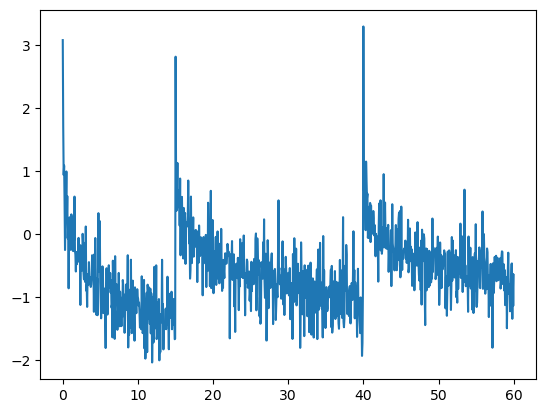

In [40]:
x = np.linspace(start = 0, stop = 60, num = 1000)
bl = []
for i in x:
    m.time = i + 0.001
    bl.append(m.get_activation(c2))
    
plt.plot(x, bl)

Plot the retrieval latency (directly related to activation) of c2:

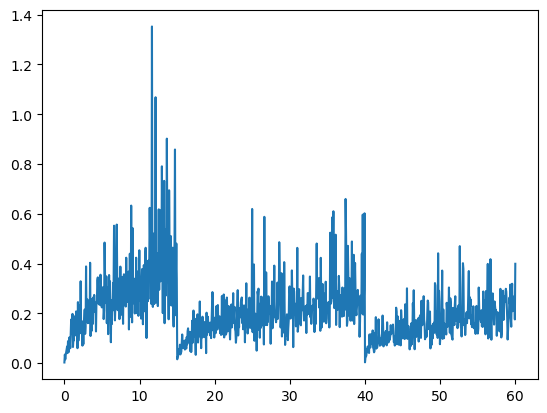

In [42]:
x = np.linspace(start = 0, stop = 60, num = 1000)
lat = []
for i in x:
    m.time = i + 0.001
    lat.append(m.get_latency(c2))
    
plt.plot(x, lat)

## Retrieving a chunk from memory
We can retrieve a chunk from memory with a retrieval pattern. We use a Chunk as a representation for that pattern:

In [46]:
pattern = Chunk(name = "retrieve", slots = {"type": "numbers", "val1" : 1})

In [48]:
chunk, latency = m.retrieve(pattern)
print(chunk)
print(latency)

Chunk c1
Slots: {'type': 'numbers', 'val1': 1, 'val2': 2, 'word': 'two'}
Encounters: [0, 35]
Fan: 0

0.08342607679705957


Retrieval failure example:

In [50]:
pattern = Chunk(name = "test", slots = {"type" : "letters"})
chunk, latency = m.retrieve(pattern)
print(chunk)
print(latency)

None
0.27182818284590454


## Blending

Aside from retrieving a single chunk, we can also retrieve a *blended trace* (see Taatgen & van Rijn, 2011). This works in much the same way as a normal retrieval, except that we also have to specify the slot for which we want the blended trace.

Blending only works with numerical slot values, so let's make a few new chunks representing some observations of game scores, and add them to the model's DM.

In [52]:
d1 = Chunk(name = "score1", slots = {"type": "gamescore", "score": 10})
m.add_encounter(d1)

m.time += 1

d2 = Chunk(name = "score2", slots = {"type": "gamescore", "score": 15})
m.add_encounter(d2)

m.time += 1

d3 = Chunk(name = "score3", slots = {"type": "gamescore", "score": 20})
m.add_encounter(d3)

m.time += 1

We can now retrieve a blended trace of the game score, representing the model's general assessment of its game performance. (Note that we specify a pattern in the same way as before, but that we also tell the model that we want a blended trace of the `score` slot specifically.) The function returns a pair containing the the blended value of for the specified slot and the latency.

(Note that the latency of a blended retrieval is just based on the retrieval threshold, so it doesn't tell you anything about the activation of the chunks involved, unlike the latency of a regular retrieval.)

In [54]:
blend_pattern = Chunk(name = "blended-test", slots = {"type": "gamescore"})

print(m.retrieve_blended_trace(blend_pattern, "score"))

(18.7707704696836, 0.27182818284590454)


Examples of invalid requests for a blended retrieval:

In [56]:
# Slot does not exist
print(m.retrieve_blended_trace(blend_pattern, "non-existent-slot"))

# Pattern does not match any chunks in DM
blend_pattern = Chunk(name = "blended-test", slots = {"type": "letters"})
print(m.retrieve_blended_trace(blend_pattern, "score"))

(None, 0.27182818284590454)
(None, 0.27182818284590454)


### Partial Matching
Partial matching can retrieve chunks that do not completely match the request. The current implementation only calculates the mismatch of numerical slot values.

Example: Retrieve a gamescore that is similar to a score of 12.

Try this retrieval a few times. You'll see that you won't always get the same chunk, and sometimes you'll get no chunk at all. This is because of fluctuations in activation noise.

In [58]:
partial_pattern = Chunk(name = "partial-test", slots = {"type" : "gamescore", "score" : 12})

In [60]:
chunk, latency = m.retrieve_partial(partial_pattern)
print(chunk, latency)

Chunk score2
Slots: {'type': 'gamescore', 'score': 15}
Encounters: [61.001]
Fan: 0
 0.10951369005209305


Adding `trace = True` will show the activation of all eligible chunks in memory, along with the mismatch penalty applied to each.

In [64]:
chunk, latency = m.retrieve_partial(partial_pattern,trace = True)
print(chunk, latency)

Chunk score1 has activation -1.276547 and penalty -0.848528
Chunk score2 has activation -1.620092 and penalty -1.039230
Chunk score3 has activation 0.231215 and penalty -1.697056
None 0.27182818284590454


### The imaginal buffer

ACT-R has a so-called imaginal buffer that you can use, in addition to the goal buffer, to temporarily store information. It is particularly handy if you want to build a new chunk that you want to add to declarative memory.

You can use the imaginal buffer in a very similar way as the goal buffer, for example by assigning a Chunk to it:

In [38]:
m = Model()
im_chunk = Chunk(name = m.new_name("imaginal"), slots = {"isa":"count-fact","num1":"two"})
m.imaginal = im_chunk
print(m)


=== Model ===
Time: 0 s 
Goal:None
Imaginal:Chunk imaginal1
Slots: {'isa': 'count-fact', 'num1': 'two'}
Encounters: []
Fan: 0

DM:



You may notice that instead of giving it a fixed name (which we often do with goals and retrieval requests), I generate a name using the new_name function, which will take the supplied string and add a digit to it to make a unique name. This is necessary if you later want to add the chunk to declarative memory, because otherwise you end up with a chunk with the same name but different slots. You can do this with:

In [40]:
m.add_encounter(m.imaginal) # add the chunk to declarative memory
m.imaginal = None # clear the imaginal buffer
print(m)


=== Model ===
Time: 0 s 
Goal:None
Imaginal:None
DM:Chunk imaginal1
Slots: {'isa': 'count-fact', 'num1': 'two'}
Encounters: [0]
Fan: 0

Chunk count-fact
Slots: {'name': 'count-fact'}
Encounters: [0]
Fan: 2

Chunk two
Slots: {'name': 'two'}
Encounters: [0]
Fan: 2




Finally, the imaginal buffer can also spread activation, just like the goal does. By default its spreading activation is set to zero, so if you want to use it, you need to set its parameter.

In [42]:
m = Model()
im_chunk = Chunk(name = m.new_name("imaginal"), slots = {"isa":"count-fact","num1":"two"})
m.imaginal = im_chunk
m.imaginal_spreading = 1.0

c1 = Chunk(name = "c1", slots = {"type": "numbers", "val1": 1, "val2": 2, "word": "two"})
c2 = Chunk(name = "c2", slots = {"type": "numbers", "val1": 2, "val2": 3, "word": "three"})

m.add_encounter(c1)
m.add_encounter(c2)
m.time += 1.0

print("c1: %f" % m.get_spreading_activation(c1))
print("c2: %f" % m.get_spreading_activation(c2))

c1: 1.306853
c2: 0.000000
